# Build Customized RAG Pipeline

### Indexing Pipeline

Here,

1.) Fetch

2.) Convert

3.) Embed

The document splitting step is omitted since only short websides are used.


### Preliminaries

Since we will be using the Cohere Embedder Component, which requires a `CO_API_KEY` or `COHERE_API_KEY` environment variable, follow these steps to set it up:

- **Sign Up for Cohere:** Visit the [Cohere](https://cohere.com/) website and sign up for a free account. 
- **Generate a Free API Key:** After signing in, navigate to the dashboard and generate an API key.
    - The free tier provides access to trial API keys, which are rate-limited and intended for non-commercial use.
- **Add the API Key to this Project:** In the `.env` file, add your API key as follows: `CO_API_KEY="<your-api-key>"`

When the `CO_API_KEY` environment variable is set via the `.env` file, you don’t need to explicitly pass the `api_key` to the `CohereDocumentEmbedder`component.

In [18]:
from dotenv import load_dotenv
load_dotenv()

True

### About Cohere

Cohere ("Do whatever it takes to scale intelligence to serve humanity") is an AI company founded in 2019 that specializes in developing customizable, enterprise-grade AI models with a strong focus on data privacy and security. The company recently raised $500 million, reaching a valuation of $5.5 billion, and is known for its innovative language models like _Aya 23_, which excel in multilingual natural language processing. Cohere’s AI solutions are cloud-agnostic, making them adaptable to various deployment environments.

### Set up the Data Store

In [12]:
from haystack.document_stores.in_memory import InMemoryDocumentStore

document_store = InMemoryDocumentStore()

### Import the Components 

In [13]:
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument
from haystack_integrations.components.embedders.cohere import CohereDocumentEmbedder
from haystack.components.writers import DocumentWriter

fetcher = LinkContentFetcher()
converter = HTMLToDocument()
embedder = CohereDocumentEmbedder(model="embed-english-v3.0", )
writer = DocumentWriter(document_store=document_store)

### Build the Indexing-Pipeline

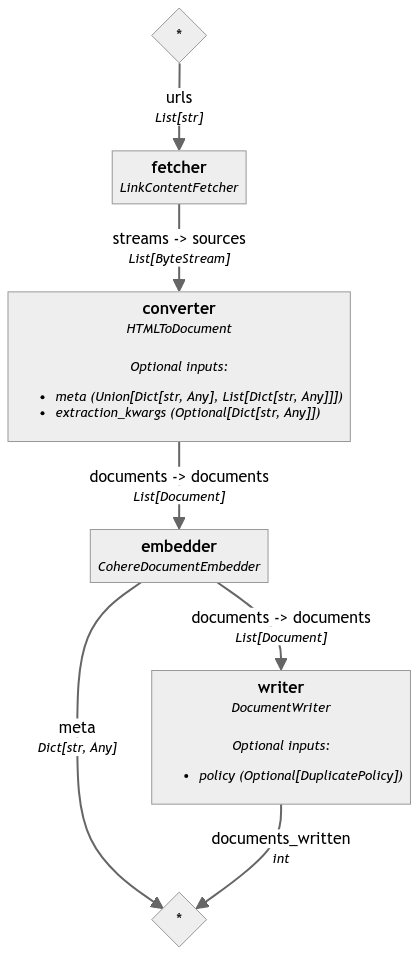

In [14]:
from haystack import Pipeline

indexing = Pipeline()

indexing.add_component("fetcher", fetcher)
indexing.add_component("converter", converter)
indexing.add_component("embedder", embedder)
indexing.add_component("writer", writer)

indexing.connect("fetcher.streams", "converter.sources")
indexing.connect("converter", "embedder")
indexing.connect("embedder", "writer")

indexing.show()

In [15]:
indexing.run(
    {
        "fetcher": {
            "urls": [
                "https://haystack.deepset.ai/integrations/cohere",
                "https://haystack.deepset.ai/integrations/anthropic",
                "https://haystack.deepset.ai/integrations/jina",
                "https://haystack.deepset.ai/integrations/nvidia",
            ]
        }
    }
)

Calculating embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


{'embedder': {'meta': ApiMeta(api_version=ApiMetaApiVersion(version='1', is_deprecated=None, is_experimental=None), billed_units=ApiMetaBilledUnits(input_tokens=2032.0, output_tokens=None, search_units=None, classifications=None), tokens=None, warnings=[])},
 'writer': {'documents_written': 4}}

In [16]:
document_store.filter_documents()[0]

Document(id=e702fd349c9d5dbb355d2554bc03fd9bc867294c5a810c201dae29fc631eb7f7, content: 'Integration: Cohere
Use Cohere models with Haystack
Table of Contents
Haystack 2.0
You can use Coher...', meta: {'content_type': 'text/html', 'url': 'https://haystack.deepset.ai/integrations/cohere'}, embedding: vector of size 1024)

### Build the RAG-Pipeline

The prompt will be used in the `PromptBuilder` component that uses Jinja templating.

In [19]:
prompt = """
Answer the question based on the provided context.
Context:
{% for doc in documents %}
   {{ doc.content }} 
{% endfor %}
Question: {{ query }}
"""

In [22]:
from haystack_integrations.components.embedders.cohere import CohereTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator

query_embedder = CohereTextEmbedder(model="embed-english-v3.0")
retriever = InMemoryEmbeddingRetriever(document_store=document_store)
prompt_builder = PromptBuilder(template=prompt)
generator = OpenAIGenerator()

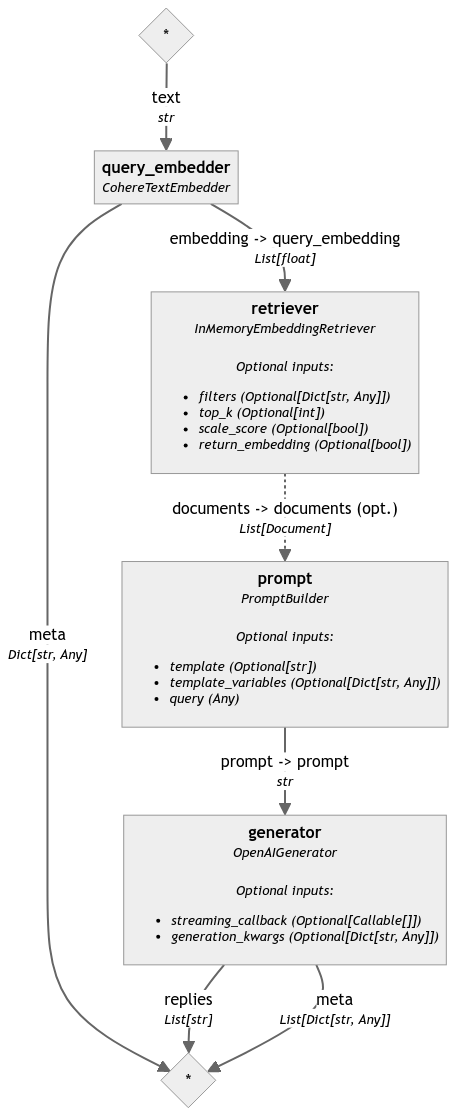

In [23]:
rag = Pipeline()

rag.add_component("query_embedder", query_embedder)
rag.add_component("retriever", retriever)
rag.add_component("prompt", prompt_builder)
rag.add_component("generator", generator)

rag.connect("query_embedder.embedding", "retriever.query_embedding")
rag.connect("retriever.documents", "prompt.documents")
rag.connect("prompt", "generator")

rag.show()

In [25]:
question = "How can I use Cohere with Haystack?"

result = rag.run(
    {
        "query_embedder": {"text": question},
        "retriever": {"top_k": 1},
        "prompt": {"query": question},
    }
)

print(result["generator"]["replies"][0])

To use Cohere with Haystack, you can follow the provided instructions for integrating Cohere models into your pipelines based on your specific use case. This includes using Cohere models for embedding documents, generating answers, and ranking documents. You can install the necessary packages with pip and use components such as CohereDocumentEmbedder, CohereTextEmbedder, CohereGenerator, and CohereRanker in combination with other components in your Haystack pipelines to leverage Cohere's capabilities for semantic embeddings, generative models, and document ranking.


### Customize the Behaviour

In [26]:
prompt = """
You will be provided some context, followed by the URL that this context comes from.
Answer the question based on the context, and reference the URL from which your answer is generated.
Your answer should be in {{ language }}.
Context:
{% for doc in documents %}
   {{ doc.content }} 
   URL: {{ doc.meta['url']}}
{% endfor %}
Question: {{ query }}
Answer:
"""

In [27]:
query_embedder = CohereTextEmbedder(model="embed-english-v3.0", api_base_url=os.getenv("CO_API_URL"))
retriever = InMemoryEmbeddingRetriever(document_store=document_store)
prompt_builder = PromptBuilder(template=prompt)
generator = OpenAIGenerator(model="gpt-3.5-turbo")

rag = Pipeline()
rag.add_component("query_embedder", query_embedder)
rag.add_component("retriever", retriever)
rag.add_component("prompt", prompt_builder)
rag.add_component("generator", generator)

rag.connect("query_embedder.embedding", "retriever.query_embedding")
rag.connect("retriever.documents", "prompt.documents")
rag.connect("prompt", "generator")

🚅 Components
  - query_embedder: CohereTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt: PromptBuilder
  - generator: OpenAIGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt.documents (List[Document])
  - prompt.prompt -> generator.prompt (str)

In [30]:
question = "How can I use Cohere with Haystack?"

result = rag.run(
    {
        "query_embedder": {"text": question},
        "retriever": {"top_k": 1},
        "prompt": {"query": question, "language": "German"},
    }
)

print(result["generator"]["replies"][0])

Sie können Cohere-Modelle in Ihren Haystack-Pipelines mit Generatoren und Einbettungsmethoden verwenden. Sie können dies tun, indem Sie entweder CohereTextEmbedder und CohereDocumentEmbedder für Einbettungsmodelle oder CohereGenerator für generative Modelle und CohereRanker für Ranglistenmodelle initialisieren. Weitere Informationen finden Sie unter: https://haystack.deepset.ai/integrations/cohere
